首先导入相关的 `module` 、`class` 和 `function` 。

In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from dataset import SinDataset
from utils import DataLoader
from init import seed_everything, dump_args, data_generator
from model import MLP

接着使用 `args` 存储相关的参数，同时使用 `dump_args` 导出本次运行的参数到文件。

In [2]:
args = {}
args["epoches"] = 2000
args["batch_size"] = 64
args["learning_rate"] = 0.003
args["record_path"] = "./record/sin"
args["save_path"] = "./save/sin/best_model.pkl"
args["data_path"] = "./data/sin/data.npz"
args["random_seed"] = 42
args["mode"] = "train_and_test"  # ["train", "test", "train_and_test"]

record_path = dump_args(args, args["record_path"], False, args["mode"])  # 如果要保存到日志文件，须设置参数 log=True

2023-10-14 13:37:28,516 P45284 INFO Dump args: {
    "epoches": 2000,
    "batch_size": 64,
    "learning_rate": 0.003,
    "record_path": "./record/sin",
    "save_path": "./save/sin/best_model.pkl",
    "data_path": "./data/sin/data.npz",
    "random_seed": 42,
    "mode": "train_and_test",
    "hash_id": "4175fef0"
}


使用 `seed_everything` 设置随机数种子，确保整个过程可重复。

In [3]:
seed_everything(args["random_seed"])

尝试加载训练数据，如果训练数据不存在，则通过 `data_generator` 生成。加载数据后初始化训练集和验证集。

In [4]:
if not os.path.exists(args["data_path"]):
    data_generator(args["data_path"])
data_npz = np.load(args["data_path"])

dataset_train = SinDataset(data_npz["x_train"], data_npz["y_train"])
dataloader_train = DataLoader(dataset_train, args["batch_size"], shuffle=True)

dataset_valid = SinDataset(data_npz["x_valid"], data_npz["y_valid"])
dataloader_valid = DataLoader(dataset_valid, args["batch_size"], shuffle=False)

初始化拟合器对象，然后尝试加载预训练的模型。

In [5]:
mlp = MLP(1, 1)
if os.path.exists(args["save_path"]):
    mlp.load_model(args["save_path"])
    print(mlp.best)

2023-10-14 13:37:35,074 P45284 INFO Load model from ./save/sin/best_model.pkl
{'valid_loss': 1.834817427189878e-06, 'train_loss': 1.9070189869965042e-06}


接着根据当前的 `args["mode"]` 判断是否进行训练。

In [ ]:
if args["mode"] == "train" or args["mode"] == "train_and_test":
    mlp.fit(
        train_loader=dataloader_train,
        valid_loader=dataloader_valid,
        epoches=args["epoches"],
        learning_rate=args["learning_rate"],
        save_path=args["save_path"],
        log_interval=50,
    )

最后可以进行测试集上的测试。

2023-10-09 15:17:54,194 P40232 INFO Test mean error: 0.001455


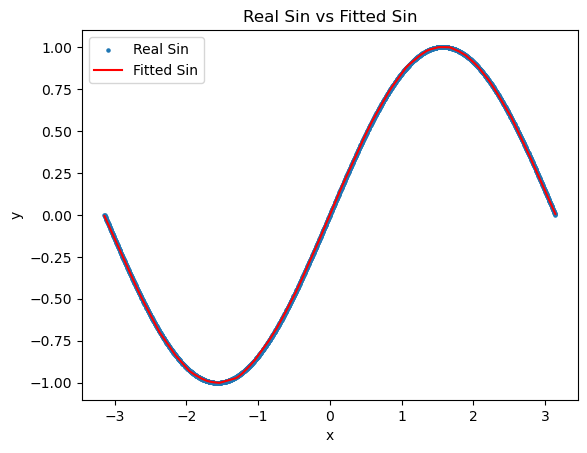

In [6]:
if args["mode"] != "test" and args["mode"] != "train_and_test":
    exit(0)
dataset_test = SinDataset(data_npz["x_test"], data_npz["y_test"])
dataloader_test = DataLoader(dataset_test, args["batch_size"], shuffle=False)

delta = 0.0
for batch in dataloader_test:
    predicts = mlp.predict(batch["x"])
    delta += np.sum(np.abs(predicts - batch["y"])) / args["batch_size"]
delta /= len(dataloader_test)
logging.info("Test mean error: {:.6f}".format(delta))

# 绘图对比
fig, ax = plt.subplots()
x = np.linspace(-np.pi, np.pi, 2000)
y = np.sin(x)
y_fit = mlp.predict(x.reshape(2000, 1)).reshape(2000)
ax.scatter(x, y, label="Real Sin", s=5)
ax.plot(x, y_fit, "r", label="Fitted Sin")
ax.set_title("Real Sin vs Fitted Sin")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()